In [55]:
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
import functions as func
import matplotlib.pyplot as plt
import pdb, glob, mpld3
from mpld3 import plugins

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)
mpld3.enable_notebook()

In the next cell, provide path to bcd files to get a sorted list of bcd filenames
- For NGC 2506, use: ../ngc2506/unzipped_AORs/ch1/bcd/*_bcd.fits
- For NGC 2420, use: ../ngc2420/r16272384/ch1/bcd/*_bcd.fits    

*Path name will change based on what channel and AOR you want*  
*If you are not Rafia, your path will be the directory in which you kept your bcd files in your local machine* 

In [56]:
bcd_fnames = np.sort(glob.glob(raw_input("BCD files directory:")))

BCD files directory:../ngc2420/r16272384/ch1/bcd/*_bcd.fits


Provide csv files that contain information about G type reference stars in the clusters
- NGC 2506: ../g_starsNGC2506.csv
- NGC 2420: ../g_starsNGC2420.csv

In [57]:
src_info = ascii.read(raw_input("reference star file:"))
src_info

reference star file:../g_starsNGC2420.csv


Name,Color (g-r),g,SpType,ra,dec,K mag,K mag err,coord hms
str14,float64,float64,str4,float64,float64,float64,float64,str26
O-0738133+2130,0.369,16.6366,G0 V,114.555525,21.5055561111,14.857,0.005,07 38 13.326 +21 30 20.002
O-0738138+2132,0.3876,17.2157,G0 V,114.557745833,21.5483188889,15.453,0.008,07 38 13.859 +21 32 53.948
O-0738152+2137,0.3132,16.442,G0 V,114.563670833,21.6280783333,14.913,0.005,07 38 15.281 +21 37 41.082
O-0738174+2128,0.3769,17.1202,G0 V,114.572554167,21.4750002778,15.392,0.007,07 38 17.413 +21 28 30.001
O-0738246+2134,0.4139,17.0974,G0 V,114.602816667,21.5772380556,15.175,0.006,07 38 24.676 +21 34 38.057
O-0738354+2138,0.4147,17.2887,G0 V,114.647841667,21.6384333333,15.478,0.008,07 38 35.482 +21 38 18.36
O-0738476+2135,0.3575,16.6174,G0 V,114.698383333,21.5966052778,14.899,0.005,07 38 47.612 +21 35 47.779
O-0738027+2130,0.4305,17.3943,G2 V,114.511483333,21.5158444444,15.517,0.008,07 38 02.756 +21 30 57.04
O-0738161+2132,0.439,17.4739,G2 V,114.567116667,21.54187,15.586,0.008,07 38 16.108 +21 32 30.732


In [58]:
#Extracting source star coordinates in the proper format

src_crd = np.array([src_info['ra'], src_info['dec']]).T
src_crd

array([[ 114.555525  ,   21.50555611],
       [ 114.55774583,   21.54831889],
       [ 114.56367083,   21.62807833],
       [ 114.57255417,   21.47500028],
       [ 114.60281667,   21.57723806],
       [ 114.64784167,   21.63843333],
       [ 114.69838333,   21.59660528],
       [ 114.51148333,   21.51584444],
       [ 114.56711667,   21.54187   ],
       [ 114.57109583,   21.60606583],
       [ 114.59358333,   21.61540806],
       [ 114.61861667,   21.55805778]])

In [59]:
#Function to convert source star sky coordinates to pixel coordinates of an image

def get_pixel_crd(crd, header):
    w = WCS(header)
    pixcrd = w.wcs_world2pix(crd,1)
    return pixcrd

#Function that generates column names for the data table to be saved
def make_colnames(n_ref_star):
    colname = ['File#', 'Time']
    for i in range(n_ref_star):
        colname.append('Star%i_Raw' % (i+1))
        colname.append('Star%i_Res' % (i+1))
    return tuple(colname)

In [60]:
# Creating data table
data  = Table(names = make_colnames(len(src_crd)))

for bcd in bcd_fnames[1::2]: #Skipping every even files to avoid short exposure images
    
    #Accessing header and data of the bcd fits files
    hdu    = fits.open(bcd)
    header = hdu[0].header
    image  = hdu[0].data
    hdu.close()
    
    time       = header['MJD_OBS']  # time in modified julian date
    fnum       = bcd[54:57]         # File number
    src_pixcrd = get_pixel_crd(src_crd, header)  #Converting source coordinates to pixel coordinates
    
    row = [fnum, time] #The row to be added 
    for i, pix in enumerate(src_pixcrd):
        
        if (pix[0]>0) & (pix[0]<256) & (pix[1]>0) & (pix[1]<256):  #If target is within FOV
            
            # 2D gaussian fitting to determine the center
            cenX, cenY = func.gen_center_g2d(pix[0], pix[1], 3, 5, 4, 4, 0, image) 
            
            # Extracting raw flux
            raw_flux, src_ap = func.photometry(image, [cenX], [cenY], rad = 3)
            
            # Extrating a mean background flux
            bkg, bkg_ap = func.photometry(image, [cenX], [cenY], shape = 'CircAnn', r_in = 4, r_out = 5)
            bkg_mean = bkg/bkg_ap.area()
            bkg_flux = bkg_mean*src_ap.area()
            
            # Subtracting background
            res_flux  = raw_flux - bkg_flux
            
        else:   # Assigning a placeholder value to stars outside of FOV
            
            raw_flux = 0.0
            res_flux = 0.0
            
        row.append(raw_flux)
        row.append(res_flux)
        
    data.add_row(row)

data

File#,Time,Star1_Raw,Star1_Res,Star2_Raw,Star2_Res,Star3_Raw,Star3_Res,Star4_Raw,Star4_Res,Star5_Raw,Star5_Res,Star6_Raw,Star6_Res,Star7_Raw,Star7_Res,Star8_Raw,Star8_Res,Star9_Raw,Star9_Res,Star10_Raw,Star10_Res,Star11_Raw,Star11_Res,Star12_Raw,Star12_Res
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,53668.3441713,0.0,0.0,9.04315045698,4.7808638754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0999851349,4.46388418285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.3446987,12.7214946372,8.08444236793,8.93973654158,4.62109898937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.036641272,4.60003913803,8.93630016825,3.95338485225,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.345194,12.9270844616,7.70595496755,9.1987605608,4.76039120737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.10595217948,4.5768966583,9.06545579091,3.95607082729,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.3457079,12.786655342,8.02520158933,8.68414925392,4.34174861773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.61776740703,4.61000296087,8.53739422297,3.58106187555,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.346245,13.2568478367,8.27214074403,9.1041781119,4.80053110076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.93647237089,4.36560497148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.3467588,12.7581736235,7.84463733879,9.06391373029,4.7239926425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.86381672845,4.60544381647,8.6964994739,3.57765031309,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.3472727,12.5019259727,8.02046128572,8.71764614806,4.34731723319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.68318180806,4.66992271786,8.20784419556,3.8091468852,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.347782,15.3887344889,10.6336166118,9.11246124089,4.92081030114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.07046773119,4.6377787119,8.80920360941,3.81168840008,0.0,0.0,0.0,0.0,0.0,0.0
0.0,53668.3483329,0.0,0.0,0.0,0.0,14.2129647588,8.61712413478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.6167550652,1.7775878462,0.0,0.0,0.0,0.0


##### Run the next cell if you want to save the data table generated from the previous cell
- Typical good names for the file should be of the format: ClusterName_dt_mmddyy_hhmm.csv
- Such as N2506_dt_080218_1117.csv (For NGC 2506)

In [61]:
#if you wan to save the data table
fname = 'ap_phot_pipeline_results/' + raw_input('Name of file to be saved:')
ow    = bool(raw_input('Overwrite any existing file with this name? (True/False)'))
ascii.write(data, fname, overwrite = ow)

Name of file to be saved:N2420_dt_080218_1422.csv
Overwrite any existing file with this name? (True/False)False


Name of Star Cluster: NGC 2420


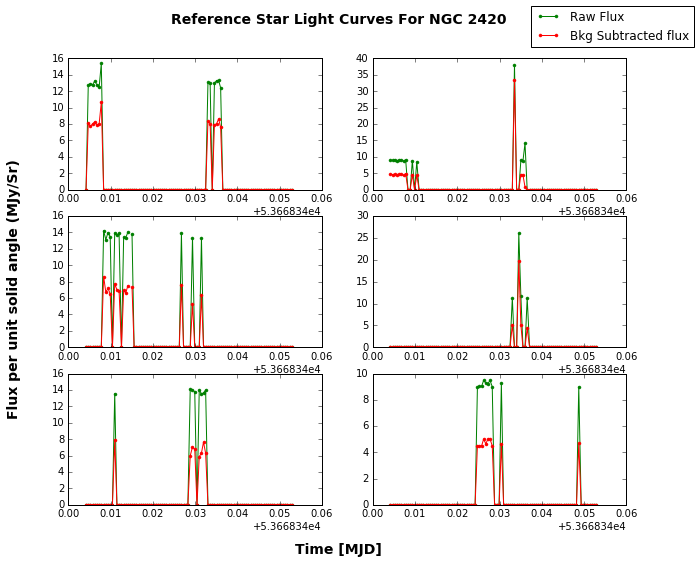

In [62]:
fig, ax = plt.subplots(3,2)

clusterName = raw_input('Name of Star Cluster: ')
fig.suptitle('Reference Star Light Curves For %s' % clusterName, fontsize=14, fontweight='bold')
fig.text(0.5, 0.04, 'Time [MJD]', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Flux per unit solid angle (MJy/Sr)', va='center', rotation='vertical', fontsize=14, 
         fontweight='bold')

ax[0,0].plot(data['Time'], data['Star1_Raw'], 'g.-')
ax[0,0].plot(data['Time'], data['Star1_Res'], 'r.-')
l1, = ax[0,1].plot(data['Time'], data['Star2_Raw'], 'g.-')
l2, = ax[0,1].plot(data['Time'], data['Star2_Res'], 'r.-')
ax[1,0].plot(data['Time'], data['Star3_Raw'], 'g.-')
ax[1,0].plot(data['Time'], data['Star3_Res'], 'r.-')
ax[1,1].plot(data['Time'], data['Star4_Raw'], 'g.-')
ax[1,1].plot(data['Time'], data['Star4_Res'], 'r.-')
ax[2,0].plot(data['Time'], data['Star5_Raw'], 'g.-')
ax[2,0].plot(data['Time'], data['Star5_Res'], 'r.-')
ax[2,1].plot(data['Time'], data['Star6_Raw'], 'g.-')
ax[2,1].plot(data['Time'], data['Star6_Res'], 'r.-')

fig.legend((l1, l2), ('Raw Flux', 'Bkg Subtracted flux'), 'upper right')

##### Run the next cell if you want to save the plot generated from the previous cell
- Typical good names for the file should be of the format: ClusterName_plt_mmddyy_hhmm.png
- Such as N2506_plt_080218_1117.png (For NGC 2506)

In [63]:
figName = 'ap_phot_pipeline_results/' + raw_input('Name of the png file to be saved:')
fig.savefig(figName)

Name of the png file to be saved:N2420_plt_080218_1424.png
